# Goal: Predict male survivorship percentage
 <center >create a regression model to predict survivorship at every ag increment instead of every 5 using the 2017 data. A unique challenge to this data set is the sparsity of the underlying <center >

In [244]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline

from scipy.optimize import minimize, curve_fit

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, LeaveOneOut,cross_validate, cross_val_predict

### Import Scraped CSV of survivorship of males by age per 100,000

In [2]:
df = pd.read_csv("Survivorship_by_age_males_CDC.csv", index_col = 0, thousands=",")  # reads scrapped CSV file
# convert to probability
df

,2017,1999–2001,1989–1991,1979–1981,1969–1971,1959–1961,1949–1951,1939–1941,1929–1931,1919–1921,1909–1911,1900–1902
0,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
1,99370,99239,98961,98607,97755,97087,96661,94762,93440,91745,87505,86426
5,99261,99095,98754,98333,97395,96643,96077,93624,91294,88505,82718,80548
10,99199,99008,98627,98160,97151,96375,95726,93054,90346,87184,81249,78775
15,99107,98890,98464,97972,96904,96107,95366,92508,89561,86156,80261,77681
20,98749,98426,97854,97316,96126,95491,94695,91617,88220,84440,78792,75984
25,98071,97747,97049,96361,95040,94631,93791,90385,86359,82252,76675,73472
30,97235,97114,96166,95430,94072,93826,92861,89009,84346,79890,74378,70747
35,96284,96385,95091,94501,92997,92889,91760,87371,82075,77514,71614,67752
40,95196,95389,93761,93345,91541,91572,90207,85246,79357,74432,68297,64447


Need to turn these values into probabilities!

In [3]:
df_prob = df.div(100_000)  # division by 100,000
df_prob

,2017,1999–2001,1989–1991,1979–1981,1969–1971,1959–1961,1949–1951,1939–1941,1929–1931,1919–1921,1909–1911,1900–1902
0,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
1,0.99370,0.99239,0.98961,0.98607,0.97755,0.97087,0.96661,0.94762,0.93440,0.91745,0.87505,0.86426
5,0.99261,0.99095,0.98754,0.98333,0.97395,0.96643,0.96077,0.93624,0.91294,0.88505,0.82718,0.80548
10,0.99199,0.99008,0.98627,0.98160,0.97151,0.96375,0.95726,0.93054,0.90346,0.87184,0.81249,0.78775
15,0.99107,0.98890,0.98464,0.97972,0.96904,0.96107,0.95366,0.92508,0.89561,0.86156,0.80261,0.77681
20,0.98749,0.98426,0.97854,0.97316,0.96126,0.95491,0.94695,0.91617,0.88220,0.84440,0.78792,0.75984
25,0.98071,0.97747,0.97049,0.96361,0.95040,0.94631,0.93791,0.90385,0.86359,0.82252,0.76675,0.73472
30,0.97235,0.97114,0.96166,0.95430,0.94072,0.93826,0.92861,0.89009,0.84346,0.79890,0.74378,0.70747
35,0.96284,0.96385,0.95091,0.94501,0.92997,0.92889,0.91760,0.87371,0.82075,0.77514,0.71614,0.67752
40,0.95196,0.95389,0.93761,0.93345,0.91541,0.91572,0.90207,0.85246,0.79357,0.74432,0.68297,0.64447


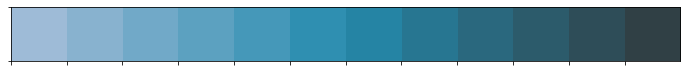

In [4]:
my_palette = sns.color_palette("PuBuGn_d", len(df_prob.columns))
my_palette.reverse()
sns.palplot(my_palette)   # plots the pallete

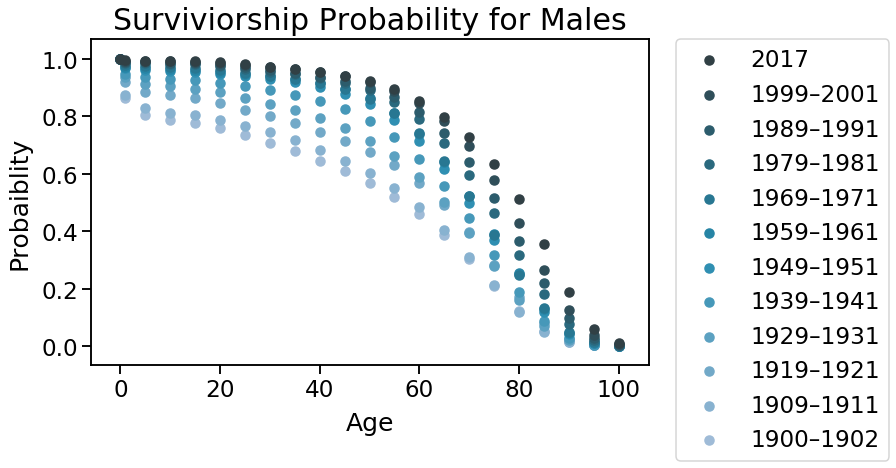

In [5]:
num_years = len(df_prob.columns)
sns.set_context("talk", font_scale=1.4)

with my_palette:
    fig, axe = plt.subplots(figsize=(10,6))
    plt.title('Surviviorship Probability for Males', pad=10, fontsize=30);
    plt.ylabel('Probaiblity', labelpad=10, fontsize=25);
    plt.xlabel('Age', labelpad=10, fontsize=25);

    for i in range(len(df_prob.columns) - 1, -1, -1):  # plot from oldest to newest
        plt.scatter(df_prob.index, df_prob[df_prob.columns[i]], label=df_prob.columns[i])
        
plt.ylabel('Probaiblity', labelpad=10, fontsize=25);

handles, labels = axe.get_legend_handles_labels();  # plot legend though from newest to oldest
# reverse the order
axe.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);


Cross Validation with KFold

In [280]:
X = (df_prob.index.to_numpy()).reshape(-1, 1) # transform from row vector to column vector
Y = df_prob['2017']

splits = 5
cross_v = KFold(n_splits=splits, shuffle=True)

split_indices = list(cross_v.split(X))
print('Number of Samples in Dataset Before Split:',X.shape[0], '\nNumber of Samples in KFold after Split:', X[split_indices[1][0]].shape[0])

cross_LOO = LeaveOneOut()

RMSE_MODEL = {}

Number of Samples in Dataset Before Split: 22 
Number of Samples in KFold after Split: 17


In [7]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))


param_grid = {'polynomialfeatures__degree': np.arange(2, 10),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

In [360]:
poly_grid = GridSearchCV(PolynomialRegression(), param_grid, 
                         cv=cross_LOO, 
                         scoring='neg_mean_squared_error', 
                         verbose=1) 

poly_grid.fit(X,  Y)


Fitting 22 folds for each of 32 candidates, totalling 704 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 704 out of 704 | elapsed:    1.3s finished


GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'linearregression__fit_intercept': [True, False],
                      

In [282]:
print(poly_grid.best_params_)
print('Mean RMSE:' ,poly_grid.best_score_ )  # Mean cross-validated score of the best_estimator 
RMSE_MODEL['7th order Polynomial'] = poly_grid.best_score_

{'linearregression__fit_intercept': False, 'linearregression__normalize': True, 'polynomialfeatures__degree': 7}
Mean RMSE: -2.4589965531835217e-05


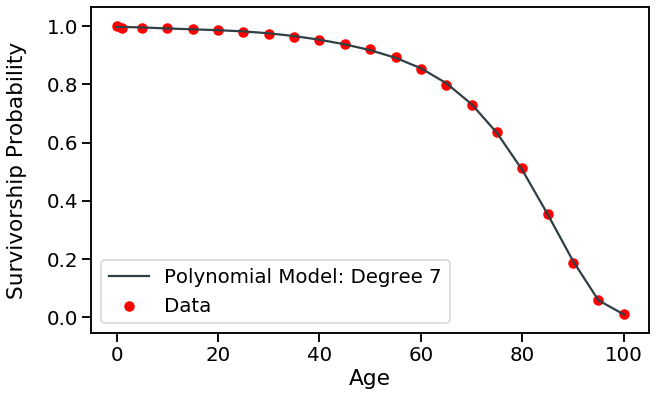

In [9]:
sns.set_context("talk", font_scale=1.2)
fig, axe = plt.subplots(figsize=(10,6))
plt.scatter(X, Y, label='Data', color='r')
plt.plot(X.ravel(), poly_grid.predict(X), color=my_palette[-1],
         label=f"Polynomial Model: Degree {poly_grid.best_params_['polynomialfeatures__degree']}")
plt.xlabel('Age')
plt.ylabel('Survivorship Probability', labelpad=20)
plt.legend()

In [356]:
from sklearn.utils.testing import warnings
# from sklearn.exceptions import warnings


def PolynomialRegressionRidge(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

lambda_range = np.linspace(0.0005, 1, 100 + 1)
param_grid_ridge = {'polynomialfeatures__degree': np.arange(2, 8),
              'lasso__alpha': lambda_range,
              'lasso__fit_intercept': [True, False],
              'lasso__normalize': [True, False],
                    'lasso__max_iter' : [5000],
                    'lasso__tol':[0.1]}

poly_grid_lasso = GridSearchCV(estimator = PolynomialRegressionRidge(),
                               param_grid = param_grid_ridge, 
                               cv = cross_LOO, 
                               scoring = 'neg_mean_squared_error', 
                               verbose = 0) 

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.simplefilter("ignore")

    poly_grid_lasso.fit(X, Y)

In [357]:
poly_grid_lasso.best_params_
print('Mean RMSE:' ,poly_grid_lasso.best_score_)  # Mean cross-validated score of the best_estimator 
RMSE_MODEL['Lasso Polynomial'] = poly_grid_lasso.best_score_

Mean RMSE: -0.0019388156595106648


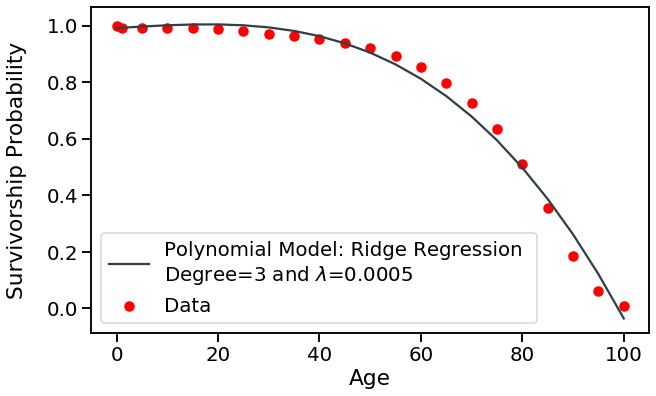

In [271]:
sns.set_context("talk", font_scale=1.2)
fig, axe = plt.subplots(figsize=(10,6))
plt.scatter(X, Y, label='Data', color='r')
plt.plot(X.ravel(), poly_grid_lasso.predict(X), color=my_palette[-1],
         label="Polynomial Model: Ridge Regression \n" + \
         f"Degree={poly_grid_lasso.best_params_['polynomialfeatures__degree']}" \
        r" and $\lambda$" + f"={poly_grid_lasso.best_params_['lasso__alpha']}")
plt.xlabel('Age')
plt.ylabel('Survivorship Probability', labelpad=20)
plt.legend()

Notice: unrealistic values with probabilites greater than 1 and less than 0 when using 3rd degree polyomial

In [272]:
all_ages_row = np.arange(1,100 + 1)
all_ages_col = all_ages.reshape(-1,1)
all_age_predict = poly_grid_lasso.predict(all_ages_col)
lasso_predict = pd.Series(data=all_age_predict, index=all_ages_row)
print("Minimum Probability" ,round(lasso_predict.min(), 3), '\nMaximim Probability' ,round(lasso_predict.max(), 3))

Minimum Probability -0.035 
Maximim Probability 1.005


In [273]:
all_age_predict = poly_grid.predict(all_ages)
poly_7_predict  = pd.Series(data=all_age_predict, index=all_ages_row)
print("Minimum Probability" ,round(poly_7_predict.min(), 3), '\nMaximim Probability' ,round(poly_7_predict.max(), 3))

Minimum Probability 0.009 
Maximim Probability 0.997


## Let's try a K-Nearst Neighbors Regression

Minimum Probability 0.035 
Maximim Probability 0.997
Mean RMSE: -0.0007172597000000002


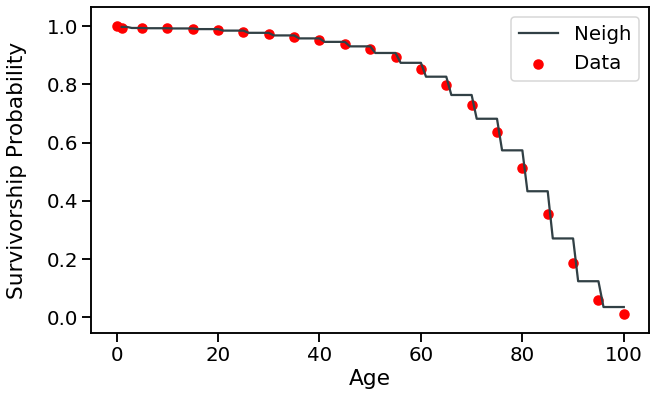

In [284]:
neigh_inst = KNeighborsRegressor(n_neighbors=2, leaf_size=30)

# cross validate model
k_neigh_predictions = cross_validate(neigh_inst, X, Y, scoring = 'neg_mean_squared_error' ,cv=cross_LOO)


neigh_inst.fit(X, Y)
all_age_predict = neigh_inst.predict(all_ages_col)

fig, axe = plt.subplots(figsize=(10,6))
plt.scatter(X, Y, label='Data', color='r')
plt.plot(all_ages_row,all_age_predict, color=my_palette[-1], label="Neigh")
plt.xlabel('Age')
plt.ylabel('Survivorship Probability', labelpad=20)
plt.legend()

neigh_predict = pd.Series(data=all_age_predict, index=all_ages_row)
print("Minimum Probability" ,round(neigh_predict.min(), 3), '\nMaximim Probability' ,round(neigh_predict.max(), 3))
print('Mean RMSE:' ,k_neigh_predictions['test_score'].mean())
RMSE_MODEL['K-Nearst Neighbors'] = k_neigh_predictions['test_score'].mean()

### Invert  Data to make logistic type data  

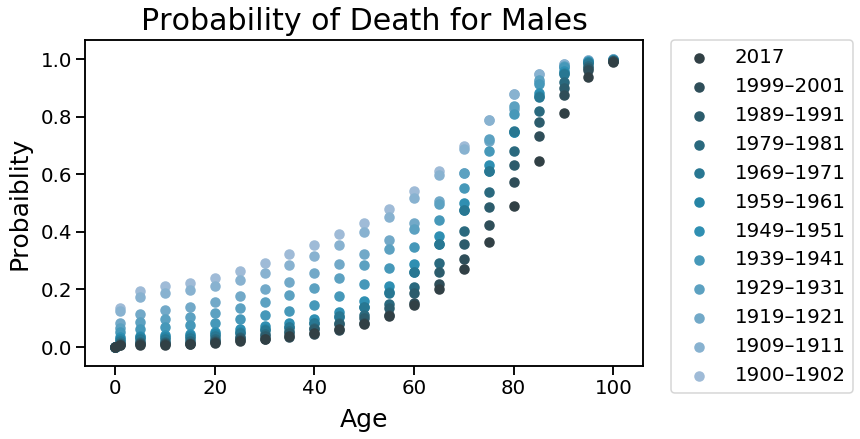

In [61]:
with my_palette:
    fig, axe = plt.subplots(figsize=(10,6))
    plt.title('Probability of Death for Males', pad=10, fontsize=30);
    plt.ylabel('Probaiblity', labelpad=10, fontsize=25);
    plt.xlabel('Age', labelpad=10, fontsize=25);

    for i in range(len(df_prob.columns) - 1, -1, -1):  # plot from oldest to newest
        plt.scatter(df_prob.index, 1 - df_prob[df_prob.columns[i]], label=df_prob.columns[i])
        
plt.ylabel('Probaiblity', labelpad=10, fontsize=25);

handles, labels = axe.get_legend_handles_labels();  # plot legend though from newest to oldest
# reverse the order
axe.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);


### Let's try a Generalised logistic function also known as Richards' curve

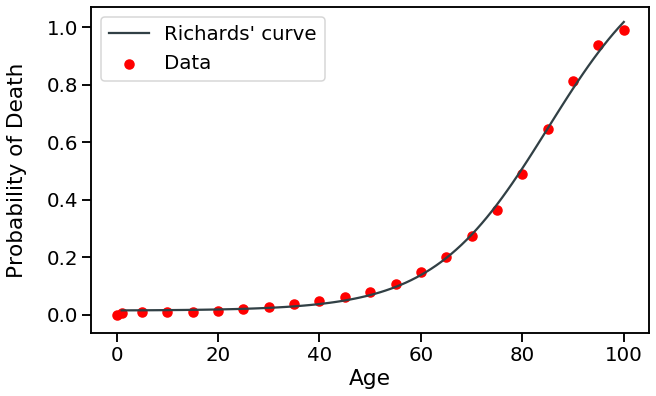

In [326]:
def my_logistic(age, x):
    A, K, B, v, Q, C, M = x
    return A + ( (K-A) / ((C + Q*np.exp(-B*(age - M)))*(1/v)) )

def minimize_logistic(x, age, y):
    y = 1 - y
    y_pred = my_logistic(age, x)
    return sum((y - y_pred)**2)

def cv_richard(cv_object,X, Y, x_0):
    CV_MSE = []
    for train_index, test_index in cv_object.split(X):
        X = X.reshape(1,-1)[0]
        X_LOO = X[train_index]
        Y_LOO = Y.values[train_index]

        optimal_min_CV = minimize(minimize_logistic, x_0, args=(X_LOO,Y_LOO), method='SLSQP')   
        y_pred = my_logistic(X[test_index],  optimal_min_CV.x)
        CV_MSE.append(mean_squared_error(Y.values[test_index], y_pred))
        
    return np.asarray(CV_MSE).mean()
    
    

x_0 = [1.36970617e-02, 2.40390375e-02, 8.88763291e-02,
       4.00538451e-01, 5.17965368e+00, 3.25971311e-03,
       2.10870166e+00]

optimal_min = minimize(minimize_logistic, x_0, args=(X.ravel(),Y), method='SLSQP')   
optimal_min.x

RMSE_MODEL["Richards'"] = cv_richard(cross_LOO, X, Y, x_0)

fig, axe = plt.subplots(figsize=(10,6))
plt.scatter(X, 1 - Y, label='Data', color='r')
plt.plot(all_ages_row, my_logistic(all_ages_row, optimal_min.x), color=my_palette[-1], label="Richards' curve")
plt.xlabel('Age')
plt.ylabel('Probability of Death', labelpad=20)
plt.legend()



### Results
$7^{th}$ degree Polynomial model most likely overfitting considering we have 7 coefficients for only 21 samples. However, it does provide probabilites:

$0 <= Pr(x) <= 1$

Lasso regression using $L_1$ penalty creatse a $3^{rd}$ degree Polynomial appears to make the model more robust with greater bias and less variance. However the residuals are worse,  MSE is greater, and probabilites outside of the domain.

$0 >=  Pr(x)  \ and \ Pr(x)  >= 1$



KFold utilized to prevent overfitting and hyperparamater selection

In [328]:
RMSE_MODEL


{'7th order Polynomial': -2.4589965531835217e-05,
 'Lasso Polynomial': -0.0016404435722515598,
 'K-Nearst Neighbors': -0.0007172597000000002,
 "Richards'": 0.6770025385810483}

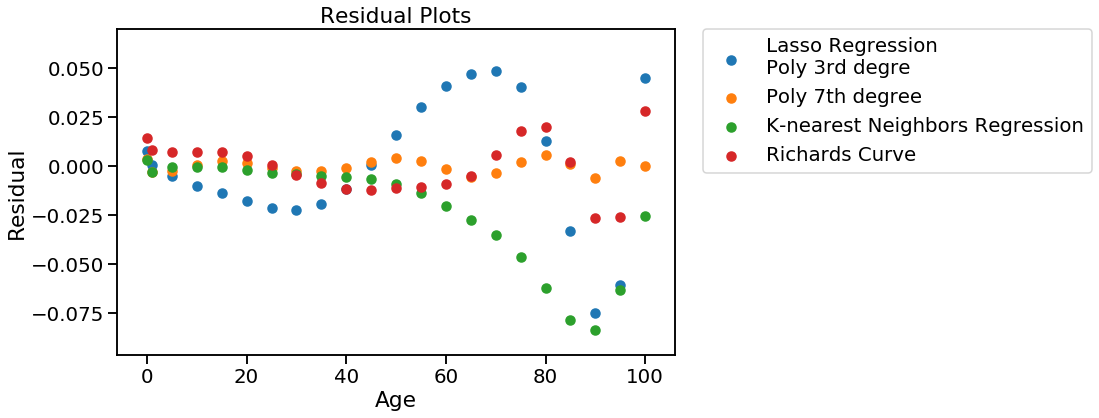

In [218]:
fig, axe = plt.subplots(figsize=(10,6))
plt.scatter(X.ravel(), Y-Y_Lasso, label='Lasso Regression \nPoly 3rd degre')
plt.scatter(X.ravel(), Y-Y_POLY, label='Poly 7th degree')
plt.scatter(X.ravel(), Y-Y_Kneigh, label = 'K-nearest Neighbors Regression')
plt.scatter(X.ravel(), Y-(1- Y_Richard), label = 'Richards Curve')

plt.xlabel('Age')
plt.ylabel('Residual')
plt.title("Residual Plots")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);